In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")

In [63]:
df = pd.read_csv("diabetes.csv")

In [64]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,183,0,0,0,28.4,0.212,36,1
1,5,162,104,0,0,37.7,0.151,52,1
2,2,197,70,99,0,34.7,0.575,62,1
3,13,158,114,0,0,42.3,0.257,44,1
4,0,162,76,56,100,53.2,0.759,25,1
...,...,...,...,...,...,...,...,...,...
503,7,179,95,31,0,34.2,0.164,60,0
504,0,113,76,0,0,33.3,0.278,23,1
505,3,128,72,25,190,32.4,0.549,27,1
506,1,119,88,41,170,45.3,0.507,26,0


In [65]:
invalid_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[invalid_cols] = df[invalid_cols].replace(0, np.nan)

In [66]:
# Show missing values per column
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Pregnancies                   0
Glucose                       3
BloodPressure                27
SkinThickness               167
Insulin                     255
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [67]:
imputer = KNNImputer(n_neighbors=5)
df[invalid_cols] = imputer.fit_transform(df[invalid_cols])


In [68]:
df['GlucoseBin'] = pd.cut(df['Glucose'], bins=[0, 100, 140, np.inf], labels=['Low', 'Normal', 'High'])
df['BPBin'] = pd.cut(df['BloodPressure'], bins=[0, 60, 80, np.inf], labels=['Low', 'Normal', 'High'])

In [69]:
# Show missing values per column
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
GlucoseBin                  0
BPBin                       0
dtype: int64


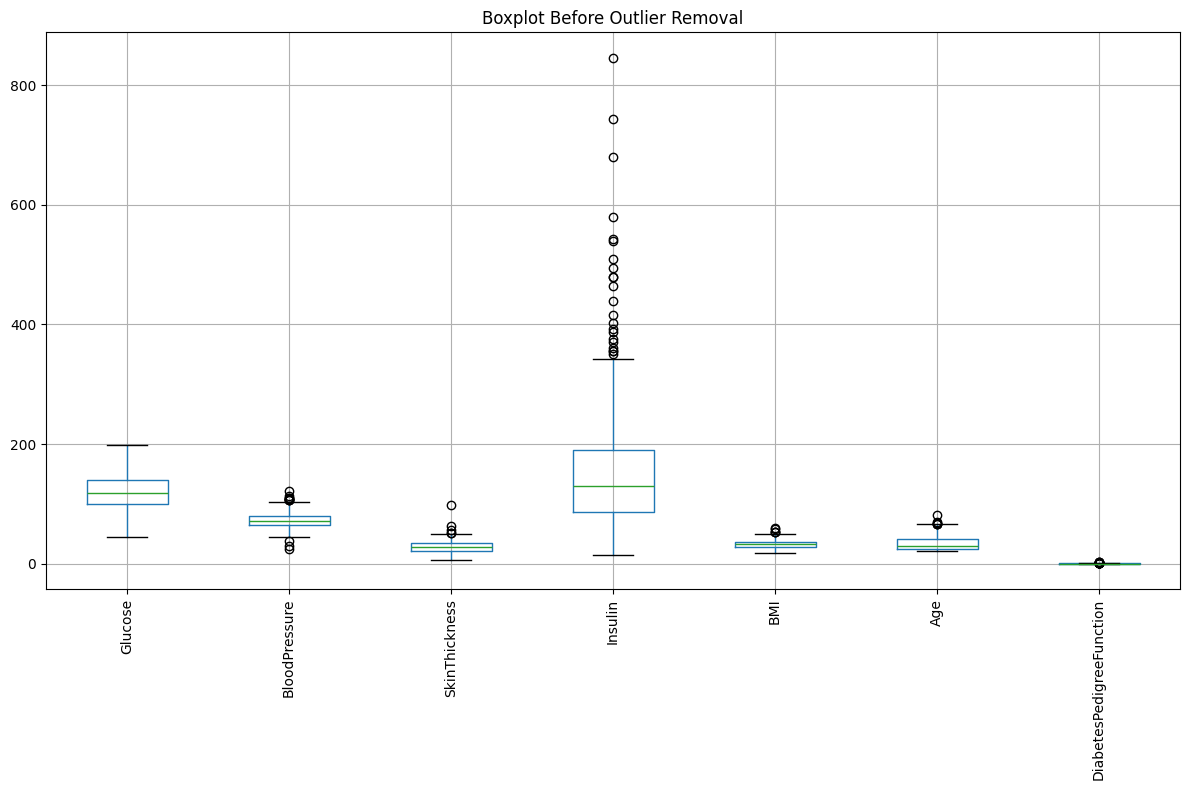


Outliers removed per column (IQR method):
Glucose: Removed 0 outliers
BloodPressure: Removed 12 outliers
SkinThickness: Removed 3 outliers
Insulin: Removed 22 outliers
BMI: Removed 3 outliers
Age: Removed 8 outliers
DiabetesPedigreeFunction: Removed 23 outliers

Total rows removed due to outliers: 71



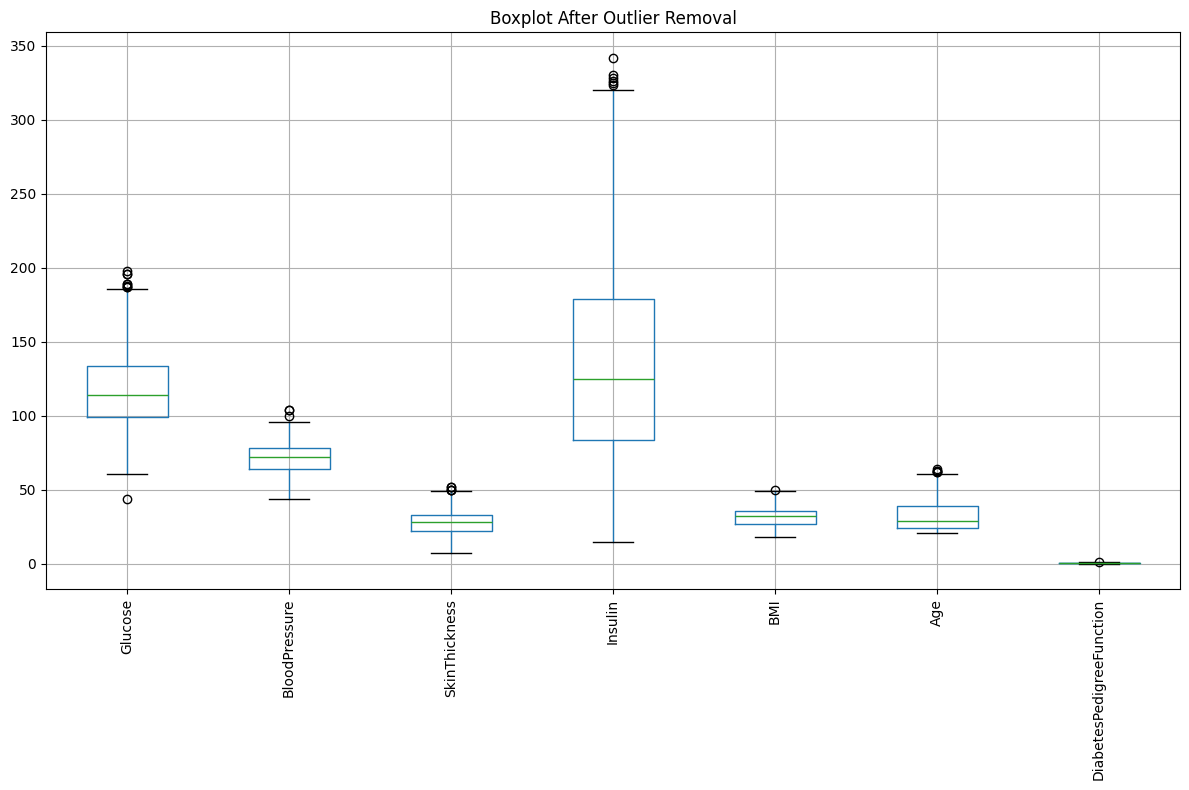

In [70]:
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'DiabetesPedigreeFunction']

# 1. Visualize outliers before removal
plt.figure(figsize=(12, 8))
df[columns_to_check].boxplot(rot=90)
plt.title("Boxplot Before Outlier Removal")
plt.tight_layout()
plt.show()

# 2. Count and remove outliers
print("\nOutliers removed per column (IQR method):")
before_total = df.shape[0]
for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    before = df.shape[0]
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    after = df.shape[0]
    print(f"{col}: Removed {before - after} outliers")

total_removed = before_total - df.shape[0]
print(f"\nTotal rows removed due to outliers: {total_removed}\n")

# 3. Visualize after removing outliers
plt.figure(figsize=(12, 8))
df[columns_to_check].boxplot(rot=90)
plt.title("Boxplot After Outlier Removal")
plt.tight_layout()
plt.show()

In [71]:
label_cols = ['GlucoseBin', 'BPBin']
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])


In [72]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GlucoseBin,BPBin
0,4,183.0,78.8,27.4,272.8,28.4,0.212,36,1,0,2
1,5,162.0,104.0,33.2,289.2,37.7,0.151,52,1,0,0
6,0,101.0,76.0,38.0,174.8,35.7,0.198,26,0,2,2
8,5,117.0,86.0,30.0,105.0,39.1,0.251,42,0,2,0
9,1,124.0,74.0,36.0,168.8,27.8,0.100,30,0,2,2


In [73]:
# Select numerical columns for scaling
numerical_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Apply Standard Scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GlucoseBin,BPBin
0,0.054371,2.319333,0.654067,-0.070802,1.966366,-0.537711,-0.884461,0.366824,1,0,2
1,0.362947,1.569260,2.937353,0.604860,2.201956,0.924681,-1.167034,1.888079,1,0,0
6,-1.179930,-0.609523,0.400369,1.164029,0.558569,0.610188,-0.949314,-0.583960,0,2,2
8,0.362947,-0.038039,1.306435,0.232081,-0.444127,1.144826,-0.703799,0.937295,0,2,0
9,-0.871355,0.211985,0.219156,0.931042,0.472377,-0.632059,-1.403284,-0.203646,0,2,2


In [74]:
X = df.drop(columns='Outcome')
y = df['Outcome']

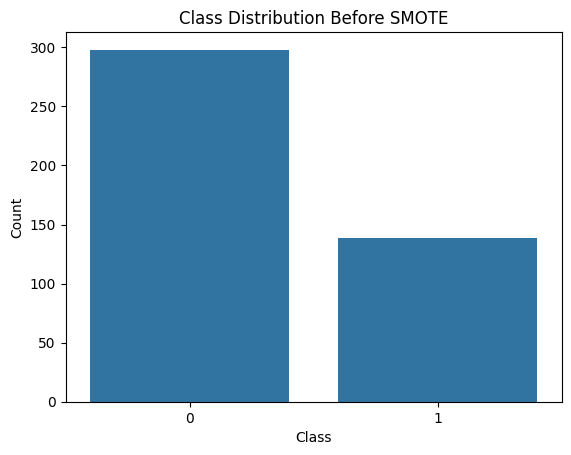


Class Distribution before SMOTE:
 Outcome
0    298
1    139
Name: count, dtype: int64


In [75]:
# Visualize class imbalance before SMOTE
sns.countplot(x='Outcome', data=df)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
print("\nClass Distribution before SMOTE:\n", y.value_counts())

In [76]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

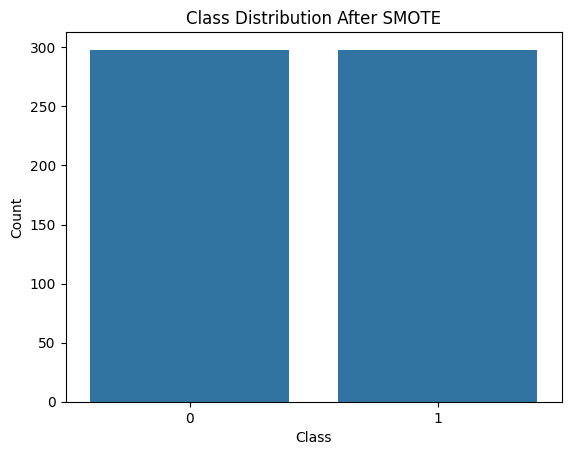


Class Distribution after SMOTE:
 Outcome
1    298
0    298
Name: count, dtype: int64


In [77]:
# Visualize after SMOTE
sns.countplot(x=y)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
print("\nClass Distribution after SMOTE:\n", pd.Series(y).value_counts())

In [78]:
# Step 1: Split 70% Train and 30% Temp (Test + Holdout)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Step 2: Split 30% Temp into 20% Test and 10% Holdout (2:1 split)
X_test, X_holdout, y_test, y_holdout = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42
)

# Confirm shape of each set
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Hold-out set:", X_holdout.shape, y_holdout.shape)


Train set: (417, 10) (417,)
Test set: (119, 10) (119,)
Hold-out set: (60, 10) (60,)


In [79]:
# prompt: import svc

from sklearn.svm import SVC

In [80]:
# Dictionary to store results
results = {}

# Define models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Get probability of the positive class

    # Evaluate the model
    clf_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n--- {name} Results ---")
    print("Classification Report:")
    print(clf_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("ROC AUC Score:", roc_auc)

    # Store results
    results[name] = {
        'classification_report': clf_report,
        'confusion_matrix': conf_matrix,
        'roc_auc_score': roc_auc,
        'model': model # Store the trained model
    }

# Optional: Summarize results
print("\n--- Model Performance Summary (ROC AUC) ---")
for name, res in results.items():
    print(f"{name}: {res['roc_auc_score']:.4f}")


Training Logistic Regression...

--- Logistic Regression Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.73        60
           1       0.71      0.80      0.75        59

    accuracy                           0.74       119
   macro avg       0.74      0.74      0.74       119
weighted avg       0.74      0.74      0.74       119

Confusion Matrix:
[[41 19]
 [12 47]]
ROC AUC Score: 0.8302259887005651

Training Random Forest...

--- Random Forest Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.81        60
           1       0.79      0.88      0.83        59

    accuracy                           0.82       119
   macro avg       0.83      0.82      0.82       119
weighted avg       0.83      0.82      0.82       119

Confusion Matrix:
[[46 14]
 [ 7 52]]
ROC AUC Score: 0.8915254237288136

Training Support Vector Machi

In [81]:
# Perform K-Fold Cross-Validation
print("\n--- K-Fold Cross-Validation Results (using StratifiedKFold on the full dataset) ---")

# Use StratifiedKFold to maintain class distribution in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    print(f"Performing cross-validation for {name}...")
    # Use cross_val_score to get the accuracy for each fold
    # 'scoring' can be changed to other metrics like 'roc_auc', 'f1', 'precision', 'recall'
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy') # Using the full dataset X, y

    cv_results[name] = {
        'fold_scores': scores,
        'mean_score': np.mean(scores),
        'std_score': np.std(scores)
    }

    print(f"{name} - Cross-Validation Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    print(f"Individual fold scores: {scores}\n")

# Optional: Summarize cross-validation results
print("\n--- Cross-Validation Performance Summary (Mean Accuracy) ---")
for name, res in cv_results.items():
    print(f"{name}: {res['mean_score']:.4f} (+/- {res['std_score']:.4f})")


--- K-Fold Cross-Validation Results (using StratifiedKFold on the full dataset) ---
Performing cross-validation for Logistic Regression...
Logistic Regression - Cross-Validation Accuracy: 0.7685 (+/- 0.0303)
Individual fold scores: [0.76666667 0.78151261 0.75630252 0.72268908 0.81512605]

Performing cross-validation for Random Forest...
Random Forest - Cross-Validation Accuracy: 0.8188 (+/- 0.0254)
Individual fold scores: [0.83333333 0.81512605 0.80672269 0.78151261 0.85714286]

Performing cross-validation for Support Vector Machine...
Support Vector Machine - Cross-Validation Accuracy: 0.7886 (+/- 0.0263)
Individual fold scores: [0.75833333 0.81512605 0.78151261 0.76470588 0.82352941]

Performing cross-validation for Decision Tree...
Decision Tree - Cross-Validation Accuracy: 0.7534 (+/- 0.0332)
Individual fold scores: [0.73333333 0.74789916 0.78151261 0.70588235 0.79831933]

Performing cross-validation for K-Nearest Neighbors...
K-Nearest Neighbors - Cross-Validation Accuracy: 0.765

In [87]:
# Hyperparameter tuning for SVC using GridSearchCV
print("\n--- Hyperparameter Tuning for Support Vector Machine (SVC) ---")

# Define the parameter grid for SVC
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Initialize GridSearchCV with the SVC model and parameter grid
# Using StratifiedKFold for cross-validation
grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42), # Use SVC
    param_grid=param_grid_svc,
    scoring='roc_auc', # Use ROC AUC as the scoring metric
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # Use Stratified K-Fold
    verbose=1, # Print progress
    n_jobs=-1 # Use all available cores
)

# Fit GridSearchCV on the training data
print("Performing Grid Search for SVC...")
grid_search_svc.fit(X_train, y_train)

# Get the best parameters and the best score
best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_
best_model_svc = grid_search_svc.best_estimator_ # Get the best trained model

print("\nBest Parameters for SVC:", best_params_svc)
print("Best ROC AUC Score from Grid Search (on cross-validation folds):", best_score_svc)

# Evaluate the best SVC model on the test set
print("\nEvaluating the best SVC model on the test set...")
y_pred_svc = best_model_svc.predict(X_test)
y_proba_svc = best_model_svc.predict_proba(X_test)[:, 1] # Get probability of the positive class

clf_report_svc = classification_report(y_test, y_pred_svc)
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test, y_proba_svc)

print("\n--- Best SVC Model Test Set Results ---")
print("Classification Report:")
print(clf_report_svc)
print("Confusion Matrix:")
print(conf_matrix_svc)
print("ROC AUC Score:", roc_auc_svc)

# You can store the best SVC model in your results dictionary if you want
# results['Support Vector Machine (Tuned)'] = {
#     'classification_report': clf_report_svc,
#     'confusion_matrix': conf_matrix_svc,
#     'roc_auc_score': roc_auc_svc,
#     'model': best_model_svc
# }


--- Hyperparameter Tuning for Support Vector Machine (SVC) ---
Performing Grid Search for SVC...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters for SVC: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best ROC AUC Score from Grid Search (on cross-validation folds): 0.8839417067640065

Evaluating the best SVC model on the test set...

--- Best SVC Model Test Set Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        60
           1       0.76      0.90      0.82        59

    accuracy                           0.81       119
   macro avg       0.82      0.81      0.81       119
weighted avg       0.82      0.81      0.81       119

Confusion Matrix:
[[43 17]
 [ 6 53]]
ROC AUC Score: 0.9048022598870056


In [89]:
y_pred = best_model_svc.predict(X_holdout)

print("\nClassification Report (Hold-Out):\n", classification_report(y_holdout, y_pred))
print("\nConfusion Matrix (Hold-Out):\n", confusion_matrix(y_holdout, y_pred))



Classification Report (Hold-Out):
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.84      0.90      0.87        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Confusion Matrix (Hold-Out):
 [[25  5]
 [ 3 27]]



Confusion Matrix on Hold-Out Set:
[[25  5]
 [ 3 27]]


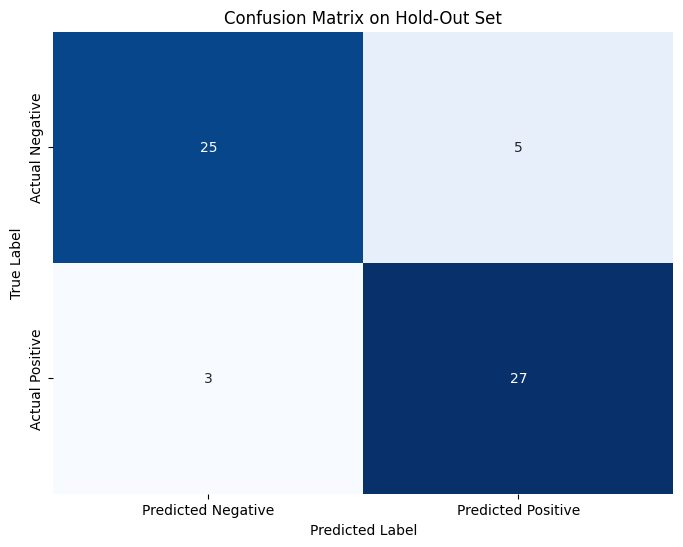

In [91]:
# prompt: print the confusion matrix on the hold out set

# Get the best performing model from the Grid Search (SVC in this case)
# Assuming 'best_model_svc' is the best estimator found by GridSearchCV

# Make predictions on the holdout set using the best model
y_pred_holdout = best_model_svc.predict(X_holdout)

# Calculate the confusion matrix
conf_matrix_holdout = confusion_matrix(y_holdout, y_pred_holdout)

print("\nConfusion Matrix on Hold-Out Set:")
print(conf_matrix_holdout)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_holdout, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Hold-Out Set')
plt.show()

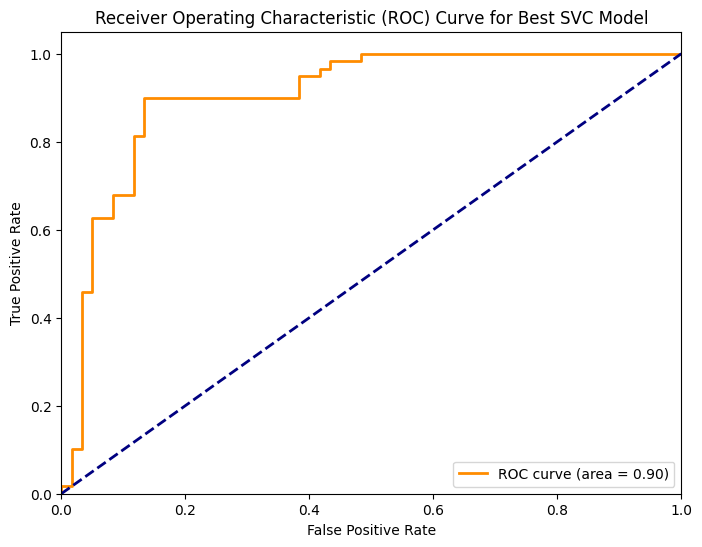

In [90]:
# prompt: plot the roc - auc curve

# Get ROC curve points for the best model (SVC)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_svc)
roc_auc = roc_auc_score(y_test, y_proba_svc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best SVC Model')
plt.legend(loc="lower right")
plt.show()